In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [3]:
df = pd.read_csv("fake_job_postings.csv", index_col="job_id")
df.head()

title            location  \
job_id                                                                  
1                                Marketing Intern    US, NY, New York   
2       Customer Service - Cloud Video Production      NZ, , Auckland   
3         Commissioning Machinery Assistant (CMA)       US, IA, Wever   
4               Account Executive - Washington DC  US, DC, Washington   
5                             Bill Review Manager  US, FL, Fort Worth   

       department salary_range  \
job_id                           
1       Marketing          NaN   
2         Success          NaN   
3             NaN          NaN   
4           Sales          NaN   
5             NaN          NaN   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3       Valor Services provides Workforce Solutions th...   
4       Our passion for improving quality of life thro...   
5       SpotSource Solutions LLC is a Global Human Cap...   

                                              description  \
job_id                                                      
1       Food52, a fast-growing, James Beard Award-winn...   
2       Organised - Focused - Vibrant - Awesome!Do you...   
3       Our client, located in Houston, is actively se...   
4       THE COMPANY: ESRI – Environmental Systems Rese...   
5       JOB TITLE: Itemization Review ManagerLOCATION:...   

                                             requirements  \
job_id                                                      
1       Experience with content management systems a m...   
2       What we expect from you:Your key responsibilit...   
3       Implement pre-commissioning and commissioning ...   
4       EDUCATION: Bachelor’s or Master’s in GIS, busi...   
5       QUALIFICATIONS:RN license in the State of Texa...   

                                                 benefits  telecommuting  \
job_id                                                                     
1                                                     NaN              0   
2       What you will get from usThrough being part of...              0   
3                                                     NaN              0   
4       Our culture is anything but corporate—we have ...              0   
5                                   Full Benefits Offered              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   
5                      1              1       Full-time    Mid-Senior level   

       required_education                   industry              function  \
job_id                                                                       
1                     NaN                        NaN             Marketing   
2                     NaN  Marketing and Advertising      Customer Service   
3                     NaN                        NaN                   NaN   
4       Bachelor's Degree          Computer Software                 Sales   
5       Bachelor's Degree     Hospital & Health Care  Health Care Provider   

        fraudulent  
job_id              
1                0  
2                0  
3                0  
4                0  
5                0

In [4]:
df.drop(columns="department", inplace=True)

In [5]:
df.drop(columns="salary_range", inplace=True)

In [6]:
df.company_profile = df.company_profile.notnull().astype('int')

In [7]:
df.description.dropna(inplace=True)

In [39]:
df.description = df.description.apply(lambda x: len(str(x)))

In [16]:
df.requirements = df.requirements.apply(lambda x: len(str(x)))

In [17]:
df.benefits = df.benefits.apply(lambda x: len(str(x)))

In [19]:
df.requirements.fillna(value=0, inplace=True)

In [20]:
df.benefits.fillna(value=0, inplace=True)

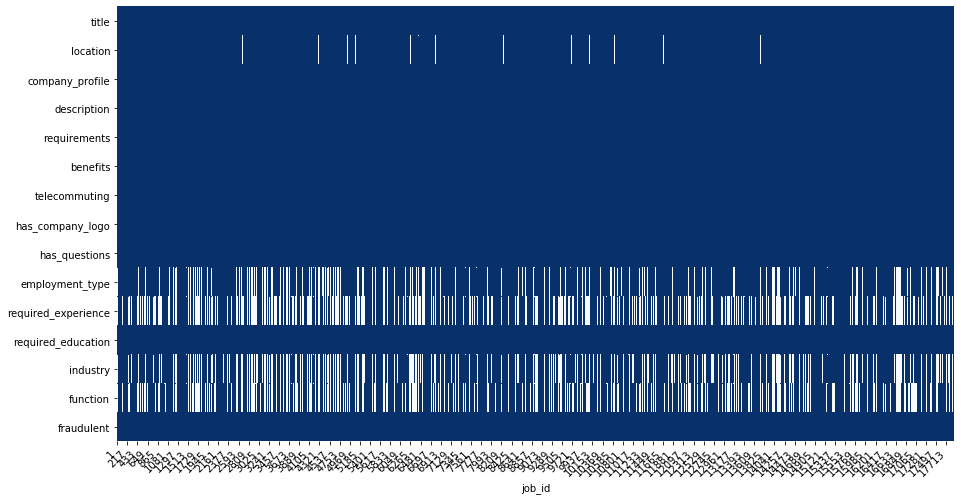

In [30]:
plot_missing_value(df)

In [23]:
df.employment_type.isna().sum()

3471

In [24]:
df.required_experience.isna().sum()

7050

In [25]:
df.required_education.isna().sum()

8105

In [26]:
df.industry.isna().sum()

4903

In [27]:
df.function.isna().sum()

6455

In [28]:
df.required_education.fillna(value="Unspecified", inplace=True)

In [29]:
df.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

In [31]:
df.employment_type.value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

## Start Machine Learning

In [40]:
X = df.drop(columns="fraudulent")
y = df.fraudulent

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14304, 14), (3576, 14), (14304,), (3576,))

## Try SVC

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [71]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC.fit(X_train, y_train)

print(model_SVC.best_params_)
print(model_SVC.score(X_train, y_train), model_SVC.best_score_, model_SVC.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  5.4min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9777138749101366 0.718656584522164 0.7787610619469026


In [50]:
gsp.svm_poly_params

{'prep__numeric__poly__degree': [1, 2, 3],
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [51]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust", poly=2), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC2 = GridSearchCV(pipeline, gsp.svm_poly_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC2.fit(X_train, y_train)

print(model_SVC2.best_params_)
print(model_SVC2.score(X_train, y_train), model_SVC2.best_score_, model_SVC2.score(X_test, y_test))

Fitting 5 folds for each of 294 candidates, totalling 1470 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1470 out of 1470 | elapsed: 20.6min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 100.0, 'algo__gamma': 0.1, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9985590778097982 0.7645226700073382 0.7999999999999998


In [52]:
from jcopml.feature_importance import mean_loss_decrease, mean_score_decrease

feature  importance     stdev
1              location    0.094446  0.007755
0                 title    0.089471  0.003418
2       company_profile    0.057298  0.008389
12             industry    0.044620  0.004933
13             function    0.044099  0.002832
5              benefits    0.039739  0.005353
3           description    0.032479  0.004526
8         has_questions    0.026537  0.001860
4          requirements    0.024694  0.002894
9       employment_type    0.022773  0.001406
11   required_education    0.019994  0.001518
7      has_company_logo    0.018038  0.001530
10  required_experience    0.010291  0.001520
6         telecommuting    0.003015  0.000538

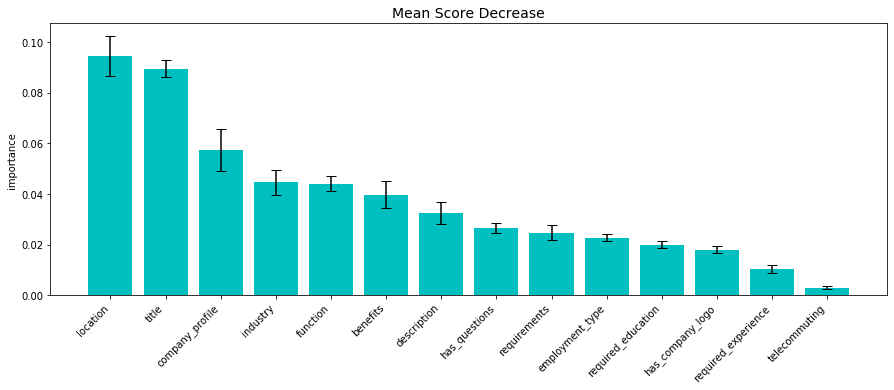

In [54]:
mean_score_decrease(X_train, y_train, model_SVC, plot=True, topk=None, n_fold=5, normalize=False, random_state=42)

## Modify SVC

In [55]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC_2 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC_2.fit(X_train, y_train)

print(model_SVC_2.best_params_)
print(model_SVC_2.score(X_train, y_train), model_SVC_2.best_score_, model_SVC_2.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  2.2min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 1.0}
1.0 0.6989494423454551 0.7484276729559749


## Try XGBoost

In [56]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [63]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust", poly=2), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBClassifier(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=5, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.0min finished


{'algo__colsample_bytree': 0.7419203085006956, 'algo__gamma': 1, 'algo__learning_rate': 0.27762530094438326, 'algo__max_depth': 7, 'algo__n_estimators': 113, 'algo__reg_alpha': 0.09444574254983565, 'algo__reg_lambda': 0.12329098365270522, 'algo__subsample': 0.5137705091792748}
0.9718518518518517 0.7012976063564033 0.7558528428093646


## Try KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [61]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__weights': ['uniform', 'distance'],
 'algo__p': [1, 1.5, 2]}

In [64]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsClassifier(weights="distance"))
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  9.1min finished


{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.7132489218988527 0.710843373493976


## SVC 3

### Remove required_experience  & required_education

In [65]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust", poly=2), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC_2 = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC_2.fit(X_train, y_train)

print(model_SVC_2.best_params_)
print(model_SVC_2.score(X_train, y_train), model_SVC_2.best_score_, model_SVC_2.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  3.0min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.953232462173315 0.6933344331453271 0.7134831460674157


### Try remove required_experience & telecommuting

In [66]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_education", 
                                               "industry", "function"]),
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVC(max_iter=500))
])

model_SVC = GridSearchCV(pipeline, gsp.svm_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
model_SVC.fit(X_train, y_train)

print(model_SVC.best_params_)
print(model_SVC.score(X_train, y_train), model_SVC.best_score_, model_SVC.score(X_test, y_test))

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 245 out of 245 | elapsed:  3.0min finished
/opt/anaconda3/envs/jcopml/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 10.0, 'algo__gamma': 0.1}
0.9885877318116976 0.758473680702966 0.7535410764872521


## Try 

In [68]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp


In [70]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling="robust"), ["description", "requirements", "benefits"]),
    ('categoric', cat_pipe(encoder='onehot'), ["title", "location", "company_profile", 
                                               "telecommuting", "has_company_logo",
                                               "has_questions", "employment_type", 
                                               "required_experience", "required_education", 
                                               "industry", "function"]),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.logreg_params, cv=5, scoring='f1', n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.0min finished


{'algo__C': 69.92636148959328, 'algo__fit_intercept': False}
0.9971139971139971 0.6664004875161698 0.7474048442906575
